In [26]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig, multi_dot, inv, matrix_power, eigh
from scipy.optimize import curve_fit
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.size']=20
from scipy.linalg import expm, sqrtm
from scipy.stats import linregress
from math import acos, factorial
from scipy.special import eval_genlaguerre, gamma, hyp1f1

In [27]:
dim=30
A=1 #Probability distribution will be P~exp(-A x^2)
sigma=np.sqrt(A/2)
basis = np.identity(dim)
i=complex(0,1)
β=1
hbar=1
tmax=0.1
n_points_t=100
xlogscale=True
if xlogscale:
    auxtmin=-1.5
    auxtmax=np.log10(tmax)
    auxt=np.linspace(auxtmin, auxtmax, n_points_t)
    t_arr=10**(auxt)
else:
    t_arr=np.linspace(0, tmax, n_points_t)
Nav=100


In [28]:
@numba.njit(float64(float64[:], float64[:]))
def braket(bra, ket):
    if np.all(bra== ket):
        return 1
    else:
        return 0
@numba.njit(complex128[:,:](complex128[:], complex128[:]))
def ketbra(ket, bra):
    dim=len(ket)
    res=np.zeros((dim, dim), dtype=complex128)
    for j in range(dim):
        for k in range(dim):
            res[j,k]=ket[j]*np.conjugate(bra[k])
    return res
#Definition of the ladder operators
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, fastmath=True, parallel=False)
def S_p(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 2*S:
        coef=0
        return (coef, ket_out)
    else:
        coef=np.sqrt(S*(S+1)-m*(m+1))
        ket_out[site+1]= 1
        return (coef, ket_out)
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, fastmath=True, parallel=False)
def S_m(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 0:
        coef=0
        return (coef, ket_out)
    else:
        coef= np.sqrt(S*(S+1)-m*(m-1))
        ket_out[site-1]= 1
        return (coef, ket_out)
@numba.jit(float64[:,:](float64[:, :], float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sx(basis, S):
    dim=int(2*S+1)
    Sx=np.zeros((dim, dim))
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sx[j, k]=(coef_p*result_p+ coef_m*result_m)/2
    return Sx
@numba.jit(float64[:,:](int64, float64), nopython=True, parallel=False, fastmath=True)
def RMT_GOE(N, sigma):
    auxH = np.random.randn(N,N)
    H=(auxH+auxH.T)
    return H
@numba.njit(complex128[:,:](int64, float64))
def RMT_GUE(N, sigma):
    H=np.zeros((N, N), dtype=complex128)
    for j in range(N):
        H[j,j]=np.random.normal(0,sigma)
        for k in range(j+1, N):
            a=np.random.normal(0,sigma)/np.sqrt(2)
            b=np.random.normal(0,sigma)/np.sqrt(2)
            H[j,k]=complex(a,b)
            H[k,j]=complex(a,-b)
    #auxH=np.random.randn(N, N)+i*np.random.randn(N, N)
    #H=(auxH+auxH.conj().T)/2
    return H

In [29]:
#@numba.njit(complex128[:](int64,complex128[:,:], float64[:], complex128[:]))
def RMT_Var_t(Nav, A, t, psi0):
    nt=len(t)
    #nt.astype('int64')
    Aav=np.zeros((Nav, nt), dtype="complex128")
    A_=A
    for j in range(Nav):
        H=RMT_GUE(dim, 1/np.sqrt(2))
        #E, _=eigh(H)
        #rhoB=expm(-β*H/4)
        #Z=np.sum(np.exp(-β*E))
        #rhoB=rhoB/Z**0.25
        #A_=inv(evec)@A@evec #A in hte basis of eigenvectors. Assuming that C=evec, A_=C^+ A C
        for k in range(nt):
            #evt=np.diag(np.exp(-i*E*t[k]))
            evt=expm(-i*H*t[k]/hbar)
            invevt=inv(evt)
            #invevt=np.diag(np.exp(i*E*t[k]))
            Aav[j,k]=np.conjugate(psi0)@invevt@A_@A_@evt@psi0-(np.conjugate(psi0)@invevt@A_@evt@psi0)**2
            #Aav[j,k]=np.conjugate(psi0)@rhoB@invevt@A_@A_@evt@rhoB@psi0-(np.conjugate(psi0)@rhoB@invevt@A_@evt@rhoB@psi0)**2
    VarAt=np.average(Aav, axis=0)
    return VarAt
            

In [30]:
G1=np.zeros((dim, dim), dtype='complex128')
G1[0,1]=1
G1[1,0]=1
#G1[2,1]=1
#G1[1,2]=1
#G2=np.eye(dim, k=1)+np.eye(dim, k=-1)
G2=Compute_Sx(basis, (dim-1)/2)
#G2.astype('complex128')
#G2=np.random.randn(dim, dim)
#G2=G2+G2.T
#psi0=np.zeros(dim)
#psi0[0]=1
#psi0[0]=1/np.sqrt(2)
#psi0[-1]=1/np.sqrt(2)
#psi0=np.random.rand(dim)
#psi0=np.random.rand(dim)+i*np.random.rand(dim)
#psi0=psi0/np.sqrt(np.sum(np.abs(psi0)**2))

In [31]:
Nav2=20
G1t_=np.zeros((Nav2, n_points_t), dtype=complex)
G2t_=np.zeros((Nav2, n_points_t), dtype=complex)
for j in range(Nav2):
    psi0=np.random.rand(dim)
    psi0=psi0/np.sqrt(np.sum(np.abs(psi0)**2))
    G1t_[j,:]=RMT_Var_t(Nav, G1, t_arr, psi0)
    G2t_[j,:]=RMT_Var_t(Nav, G2, t_arr, psi0)

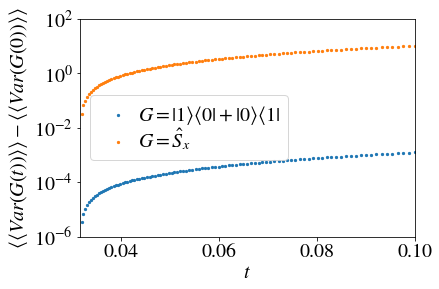

In [33]:
G1t=np.abs(np.average(G1t_, axis=0))
G2t=np.abs(np.average(G2t_, axis=0))
plt.figure()
plt.scatter(t_arr,G1t-G1t[0] , s=5, label=r"$G=|1\rangle \langle 0|+|0\rangle \langle 1|$")
plt.scatter(t_arr, G2t-G2t[0], s=5, label=r"$G=\hat{S}_x$")
plt.yscale('log')
#plt.xscale('log')
plt.xlim(t_arr[0], t_arr[-1])
#plt.plot(t_arr,1/dim**2*np.exp(dim*t_arr))
plt.ylim(1e-6,100)
plt.ylabel(r"$\langle \langle Var (G(t))\rangle \rangle -\langle \langle Var (G(0))\rangle \rangle$")
plt.xlabel("$t$")
plt.legend(labelspacing=0, handletextpad=0)
plt.show()